In [239]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

In [240]:
# Autoreload file containing helper functions
%load_ext autoreload
%autoreload 2
import data_processing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [241]:
# Load project data and set index as project id
x_df = data_processing.load_data('data/projects.csv', 'projectid')

In [242]:
# Load outcome data and set index as project id, add binary outcome variable
y_df = df = data_processing.load_data('data/outcomes.csv', 'projectid')
y_df['outcome'] = np.where(y_df['fully_funded']=='t', 1, 0)

In [243]:
# Merge outcome feature dataframe
full_df = x_df.merge(y_df, left_index = True, right_index = True)

In [244]:
# Drop extraneous data from outcome frame that could cause leakage into outcome variable
drop_cols = ['is_exciting', 'at_least_1_teacher_referred_donor',
             'at_least_1_green_donation', 'great_chat',
             'three_or_more_non_teacher_referred_donors',
             'one_non_teacher_referred_donor_giving_100_plus',
             'donation_from_thoughtful_donor', 'great_messages_proportion',
             'teacher_referred_count', 'non_teacher_referred_count', 
             'projectid_y', 'fully_funded']
full_df.drop(drop_cols, axis = 1, inplace = True)

In [245]:
# Filter for 2011 thorough 2013
full_df['date_posted'] = pd.to_datetime(full_df['date_posted'])
full_df = full_df[(full_df['date_posted'] > '2010-12-31') & (full_df['date_posted'] <'2014-01-01')]

## Preliminary Data Processing

In [246]:
# Convert all columns with binary values coded as t,f to 1,0
tf_cols = ['school_charter','school_magnet', 'school_year_round', 
           'school_nlns','school_kipp', 'school_charter_ready_promise',
           'teacher_teach_for_america','teacher_ny_teaching_fellow',
           'eligible_double_your_impact_match','eligible_almost_home_match']

for col in tf_cols:
    full_df[col] = np.where(full_df[col]=='t', 1, 0)

In [247]:
# Add month, year to df, to dummify in features
full_df['month_posted'] = full_df['date_posted'].dt.month
full_df['year_posted'] = full_df['date_posted'].dt.year

## Data Exploration

In [248]:
# Observe data structure using "head" function
full_df.head()

,projectid_x,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,outcome,month_posted,year_posted
44772,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,...,30.0,444.36,522.78,7.0,0,0,2013-12-31,1,12,2013
44773,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,...,30.0,233.24,274.40,30.0,0,0,2013-12-31,0,12,2013
44774,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,...,30.0,285.09,335.40,230.0,0,0,2013-12-31,1,12,2013
44775,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,...,30.0,232.94,274.05,18.0,0,0,2013-12-31,1,12,2013
44776,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,...,30.0,513.41,604.01,70.0,1,0,2013-12-31,0,12,2013


In [249]:
# Use "describe" to get broad understanding of range of values for each variable
full_df.describe()

,school_ncesid,school_latitude,school_longitude,school_zip,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,...,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,outcome,month_posted,year_posted
count,3.282930e+05,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,...,353151.000000,353151.000000,353151.000000,353151.000000,353050.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000
mean,2.503127e+11,36.868563,-95.398318,56301.763713,0.094444,0.085057,0.049078,0.011788,0.006637,0.006116,...,0.010211,32.220311,531.372372,625.143964,94.187169,0.317026,0.044279,0.694810,6.932805,2012.076831
std,1.648173e+11,4.927417,18.118360,31043.523511,0.292446,0.278967,0.216032,0.107932,0.081199,0.077968,...,0.100532,2.484309,844.069364,993.022780,156.987405,0.465318,0.205713,0.460488,3.591132,0.813033
min,1.000050e+10,18.249140,-171.690554,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,30.000000,37.030000,43.560000,1.000000,0.000000,0.000000,0.000000,1.000000,2011.000000
25%,6.372301e+10,33.916387,-117.246823,29388.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,30.000000,288.750000,339.710000,23.000000,0.000000,0.000000,0.000000,3.000000,2011.000000
50%,2.400090e+11,36.675826,-89.886438,60613.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,30.000000,427.270000,502.670000,31.000000,0.000000,0.000000,1.000000,8.000000,2012.000000
75%,3.904440e+11,40.680488,-80.761902,90007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,35.000000,606.720000,713.790000,100.000000,1.000000,0.000000,1.000000,10.000000,2013.000000
max,6.100008e+11,67.258157,-66.628036,99926.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,35.000000,139725.410000,164382.840000,12143.000000,1.000000,1.000000,1.000000,12.000000,2013.000000


In [250]:
full_df.columns

Index(['projectid_x', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'outcome', 'month_posted', 'year_posted'],
      dtype='object')

### Commentary

xyz

In [251]:
# Define continuous and discrete variables
continuous_cols = ['total_price_excluding_optional_support',
                   'total_price_including_optional_support',]

discrete_cols = ['school_state', 'school_metro', 'outcome', 'school_charter', 
                 'school_magnet', 'school_year_round', 'school_nlns','school_kipp', 
                 'school_charter_ready_promise', 'teacher_prefix','teacher_teach_for_america', 
                 'teacher_ny_teaching_fellow','primary_focus_subject', 'primary_focus_area',
                 'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
                 'poverty_level', 'grade_level', 
                 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'month_posted']

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


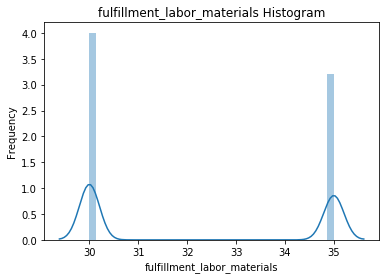

In [252]:
# Explore continuous variables
data_processing.make_histogram(full_df, 'fulfillment_labor_materials')

What do 30 and 35 mean for fulfillment? Since value is unclear, will drop in feature selection.

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


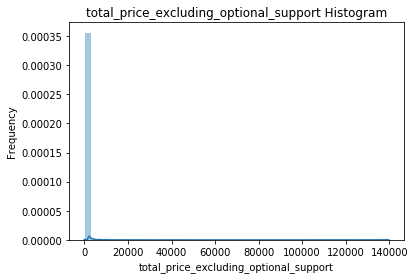

In [253]:
data_processing.make_histogram(full_df, 'total_price_excluding_optional_support')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


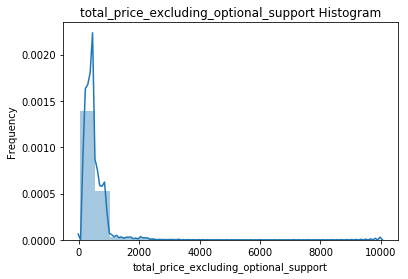

In [254]:
majority = full_df[full_df['total_price_excluding_optional_support'] < 10000]
data_processing.make_histogram(majority, 'total_price_excluding_optional_support', bins = 20)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


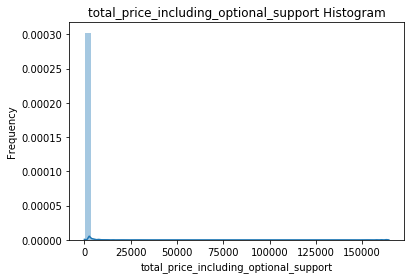

In [255]:
data_processing.make_histogram(full_df, 'total_price_including_optional_support')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


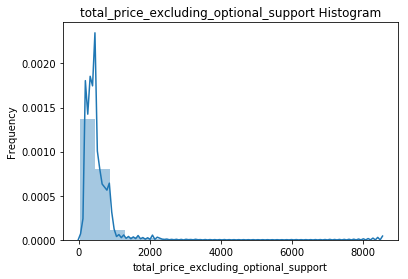

In [256]:
majority = full_df[full_df['total_price_including_optional_support'] < 10000]
data_processing.make_histogram(majority, 'total_price_excluding_optional_support', bins = 20)

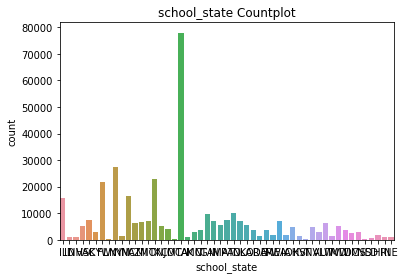

None


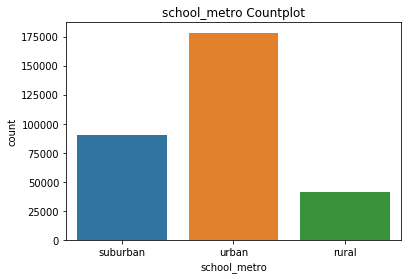

None


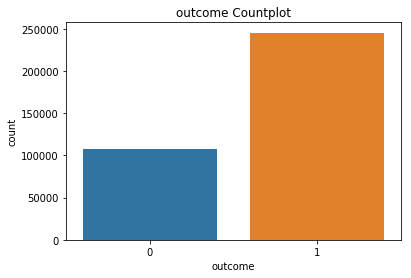

None


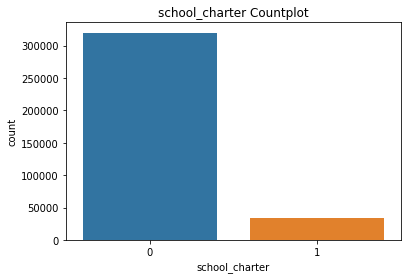

None


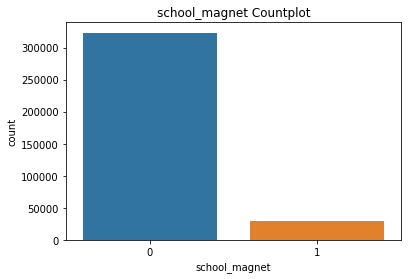

None


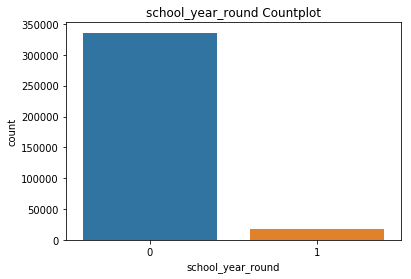

None


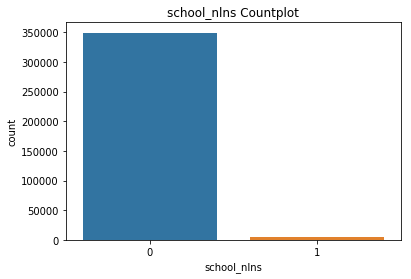

None


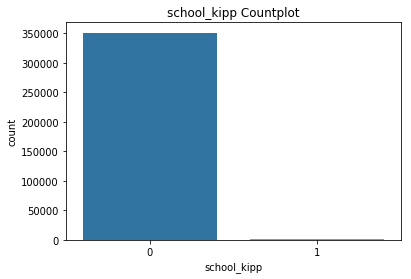

None


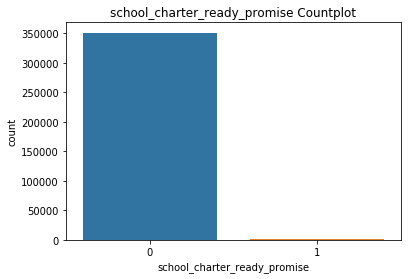

None


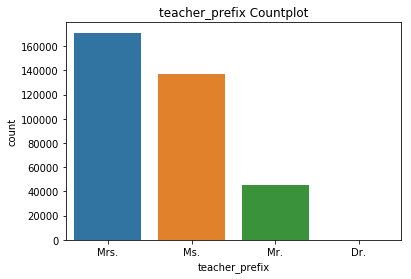

None


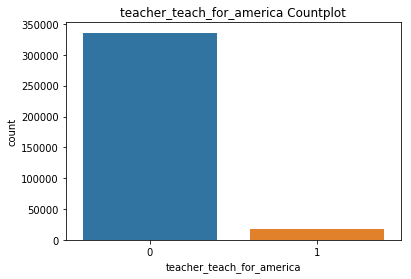

None


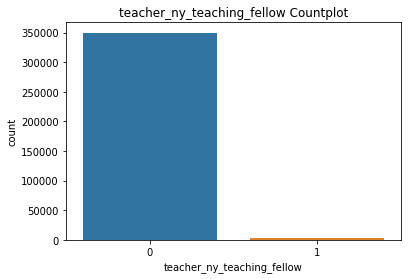

None


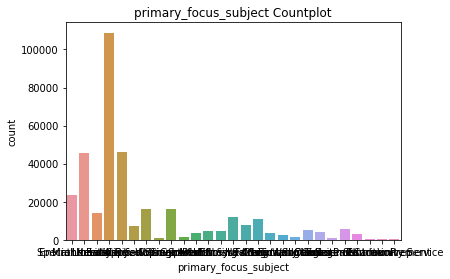

None


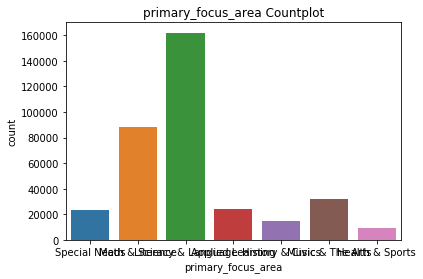

None


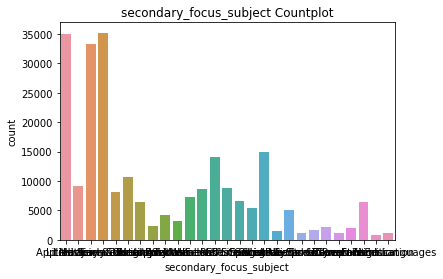

None


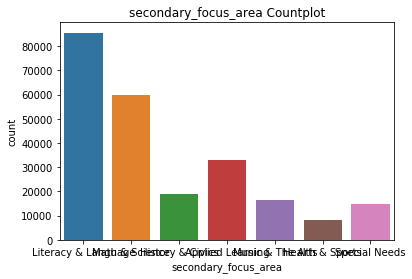

None


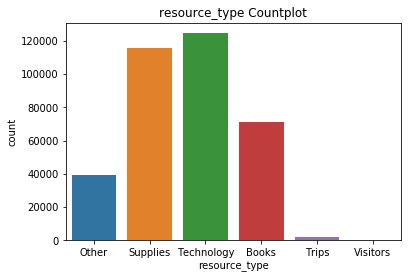

None


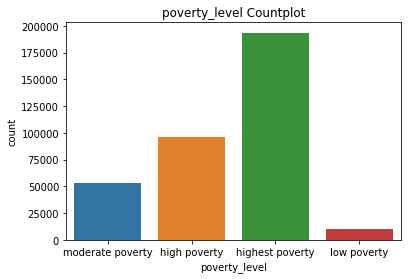

None


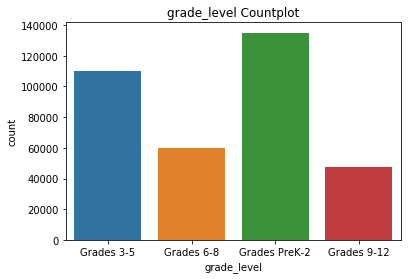

None


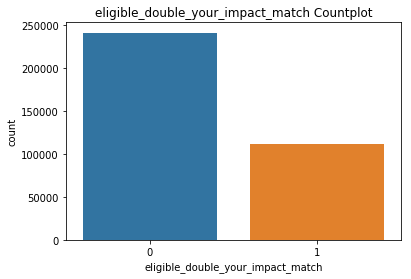

None


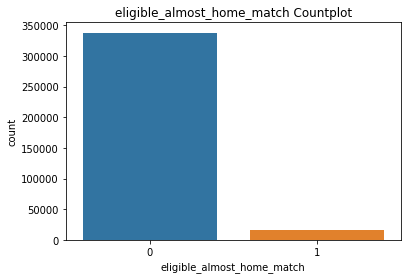

None


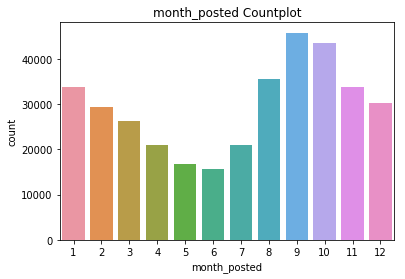

None


In [257]:
# Create countcharts for discrete variables
for col in discrete_cols:
    print(data_processing.make_countchart(full_df, col))

In [258]:
# Check correlation between dataset variables
corr = data_processing.check_correlations(full_df)

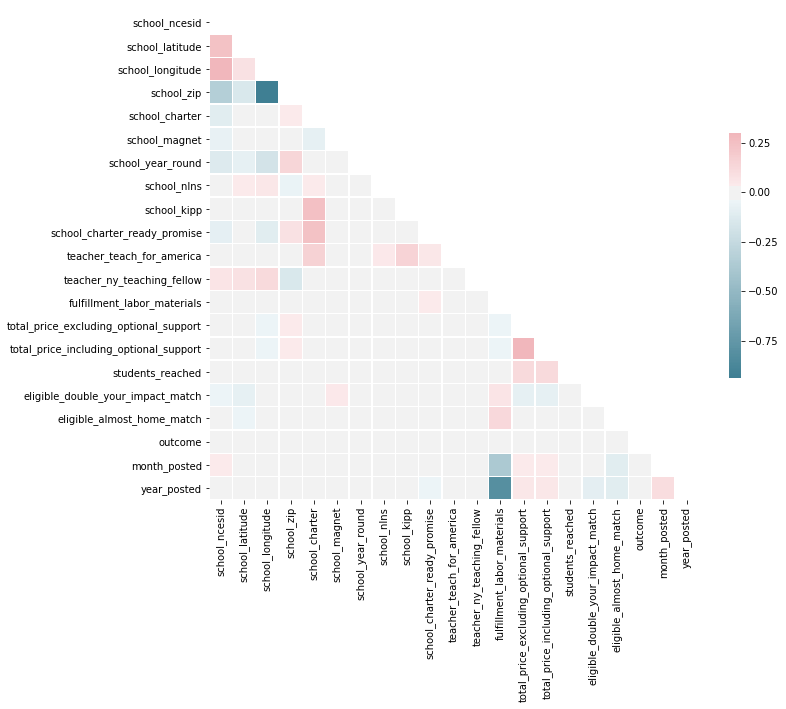

In [259]:
# Colored correlation matrix for display
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [260]:
# Check for high correlation with predictor variable
high_corr_threshold = 0.7
high_corr_vars = data_processing.find_high_corr(corr, high_corr_threshold, 'outcome')
high_corr_vars

Index(['outcome'], dtype='object')

## Commentary
Correlation between variables is generally low. Nothing is highly correlated with outcome

In [261]:
# categorical vs categorical against outcome

## Data Processing/Cleaning

In [270]:
# Identify columns with null values for imputation/additional processing, impute students_reached
isnull_cols = data_processing.cols_with_nulls(full_df)
isnull_cols

['school_ncesid', 'school_district', 'students_reached']

In [271]:
full_df = data_processing.fill_nulls(full_df,'students_reached')

### Commentary
There is no meaningful way to fill null values in any of these fields. Leave nulls as meaningful values.

There are high outlier cost, leave them in data set, most was captured in preliminary

## Generate Features/Predictors

Season, dummify other categoricals, discretize something 

In [263]:
# Categorical data to dummify
vars_to_dummify = ['school_metro', 'teacher_prefix',
                   'primary_focus_subject', 'primary_focus_area',
                   'secondary_focus_subject', 'secondary_focus_area', 
                   'resource_type','poverty_level', 'grade_level', 'month_posted', 'year_posted']

In [264]:
for var in vars_to_dummify:
    full_df = data_processing.cat_to_dummy(full_df, var)

In [266]:
# Define feature vs predictor variables
predictor = 'outcome'

max_features = [
'school_charter',
'school_magnet',
'school_year_round',
'school_nlns',
'school_kipp',
'school_charter_ready_promise',
'teacher_teach_for_america',
'teacher_ny_teaching_fellow',
'total_price_excluding_optional_support',
'total_price_including_optional_support',
'students_reached',
'eligible_double_your_impact_match',
'eligible_almost_home_match',
'school_metro_rural',
'school_metro_suburban',
'school_metro_urban',
'teacher_prefix_Dr.',
'teacher_prefix_Mr.',
'teacher_prefix_Mrs.',
'teacher_prefix_Ms.',
'primary_focus_subject_Applied Sciences',
'primary_focus_subject_Character Education',
'primary_focus_subject_Civics & Government',
'primary_focus_subject_College & Career Prep',
'primary_focus_subject_Community Service',
'primary_focus_subject_ESL',
'primary_focus_subject_Early Development',
'primary_focus_subject_Economics',
'primary_focus_subject_Environmental Science',
'primary_focus_subject_Extracurricular',
'primary_focus_subject_Foreign Languages',
'primary_focus_subject_Gym & Fitness',
'primary_focus_subject_Health & Life Science',
'primary_focus_subject_Health & Wellness',
'primary_focus_subject_History & Geography',
'primary_focus_subject_Literacy',
'primary_focus_subject_Literature & Writing',
'primary_focus_subject_Mathematics',
'primary_focus_subject_Music',
'primary_focus_subject_Nutrition',
'primary_focus_subject_Other',
'primary_focus_subject_Parent Involvement',
'primary_focus_subject_Performing Arts',
'primary_focus_subject_Social Sciences',
'primary_focus_subject_Special Needs',
'primary_focus_subject_Sports',
'primary_focus_subject_Visual Arts',
'primary_focus_area_Applied Learning',
'primary_focus_area_Health & Sports',
'primary_focus_area_History & Civics',
'primary_focus_area_Literacy & Language',
'primary_focus_area_Math & Science',
'primary_focus_area_Music & The Arts',
'primary_focus_area_Special Needs',
'secondary_focus_subject_Applied Sciences',
'secondary_focus_subject_Character Education',
'secondary_focus_subject_Civics & Government',
'secondary_focus_subject_College & Career Prep',
'secondary_focus_subject_Community Service',
'secondary_focus_subject_ESL',
'secondary_focus_subject_Early Development',
'secondary_focus_subject_Economics',
'secondary_focus_subject_Environmental Science',
'secondary_focus_subject_Extracurricular',
'secondary_focus_subject_Foreign Languages',
'secondary_focus_subject_Gym & Fitness',
'secondary_focus_subject_Health & Life Science',
'secondary_focus_subject_Health & Wellness',
'secondary_focus_subject_History & Geography',
'secondary_focus_subject_Literacy',
'secondary_focus_subject_Literature & Writing',
'secondary_focus_subject_Mathematics',
'secondary_focus_subject_Music',
'secondary_focus_subject_Nutrition',
'secondary_focus_subject_Other',
'secondary_focus_subject_Parent Involvement',
'secondary_focus_subject_Performing Arts',
'secondary_focus_subject_Social Sciences',
'secondary_focus_subject_Special Needs',
'secondary_focus_subject_Sports',
'secondary_focus_subject_Visual Arts',
'secondary_focus_area_Applied Learning',
'secondary_focus_area_Health & Sports',
'secondary_focus_area_History & Civics',
'secondary_focus_area_Literacy & Language',
'secondary_focus_area_Math & Science',
'secondary_focus_area_Music & The Arts',
'secondary_focus_area_Special Needs',
'resource_type_Books',
'resource_type_Other',
'resource_type_Supplies',
'resource_type_Technology',
'resource_type_Trips',
'resource_type_Visitors',
'poverty_level_high poverty',
'poverty_level_highest poverty',
'poverty_level_low poverty',
'poverty_level_moderate poverty',
'grade_level_Grades 3-5',
'grade_level_Grades 6-8',
'grade_level_Grades 9-12',
'grade_level_Grades PreK-2',
'month_posted_1',
'month_posted_2',
'month_posted_3',
'month_posted_4',
'month_posted_5',
'month_posted_6',
'month_posted_7',
'month_posted_8',
'month_posted_9',
'month_posted_10',
'month_posted_11',
'month_posted_12',
'year_posted_2011',
'year_posted_2012',
'year_posted_2013'   
]

In [ ]:
all_cols = [
'projectid_x',
'teacher_acctid',
'schoolid',
'school_ncesid',
'school_latitude',
'school_longitude',
'school_city',
'school_state',
'school_zip',
'school_district',
'school_county',
'school_charter',
'school_magnet',
'school_year_round',
'school_nlns',
'school_kipp',
'school_charter_ready_promise',
'teacher_teach_for_america',
'teacher_ny_teaching_fellow',
'fulfillment_labor_materials',
'total_price_excluding_optional_support',
'total_price_including_optional_support',
'students_reached',
'eligible_double_your_impact_match',
'eligible_almost_home_match',
'date_posted',
'outcome',
'school_metro_rural',
'school_metro_suburban',
'school_metro_urban',
'teacher_prefix_Dr.',
'teacher_prefix_Mr.',
'teacher_prefix_Mrs.',
'teacher_prefix_Ms.',
'primary_focus_subject_Applied Sciences',
'primary_focus_subject_Character Education',
'primary_focus_subject_Civics & Government',
'primary_focus_subject_College & Career Prep',
'primary_focus_subject_Community Service',
'primary_focus_subject_ESL',
'primary_focus_subject_Early Development',
'primary_focus_subject_Economics',
'primary_focus_subject_Environmental Science',
'primary_focus_subject_Extracurricular',
'primary_focus_subject_Foreign Languages',
'primary_focus_subject_Gym & Fitness',
'primary_focus_subject_Health & Life Science',
'primary_focus_subject_Health & Wellness',
'primary_focus_subject_History & Geography',
'primary_focus_subject_Literacy',
'primary_focus_subject_Literature & Writing',
'primary_focus_subject_Mathematics',
'primary_focus_subject_Music',
'primary_focus_subject_Nutrition',
'primary_focus_subject_Other',
'primary_focus_subject_Parent Involvement',
'primary_focus_subject_Performing Arts',
'primary_focus_subject_Social Sciences',
'primary_focus_subject_Special Needs',
'primary_focus_subject_Sports',
'primary_focus_subject_Visual Arts',
'primary_focus_area_Applied Learning',
'primary_focus_area_Health & Sports',
'primary_focus_area_History & Civics',
'primary_focus_area_Literacy & Language',
'primary_focus_area_Math & Science',
'primary_focus_area_Music & The Arts',
'primary_focus_area_Special Needs',
'secondary_focus_subject_Applied Sciences',
'secondary_focus_subject_Character Education',
'secondary_focus_subject_Civics & Government',
'secondary_focus_subject_College & Career Prep',
'secondary_focus_subject_Community Service',
'secondary_focus_subject_ESL',
'secondary_focus_subject_Early Development',
'secondary_focus_subject_Economics',
'secondary_focus_subject_Environmental Science',
'secondary_focus_subject_Extracurricular',
'secondary_focus_subject_Foreign Languages',
'secondary_focus_subject_Gym & Fitness',
'secondary_focus_subject_Health & Life Science',
'secondary_focus_subject_Health & Wellness',
'secondary_focus_subject_History & Geography',
'secondary_focus_subject_Literacy',
'secondary_focus_subject_Literature & Writing',
'secondary_focus_subject_Mathematics',
'secondary_focus_subject_Music',
'secondary_focus_subject_Nutrition',
'secondary_focus_subject_Other',
'secondary_focus_subject_Parent Involvement',
'secondary_focus_subject_Performing Arts',
'secondary_focus_subject_Social Sciences',
'secondary_focus_subject_Special Needs',
'secondary_focus_subject_Sports',
'secondary_focus_subject_Visual Arts',
'secondary_focus_area_Applied Learning',
'secondary_focus_area_Health & Sports',
'secondary_focus_area_History & Civics',
'secondary_focus_area_Literacy & Language',
'secondary_focus_area_Math & Science',
'secondary_focus_area_Music & The Arts',
'secondary_focus_area_Special Needs',
'resource_type_Books',
'resource_type_Other',
'resource_type_Supplies',
'resource_type_Technology',
'resource_type_Trips',
'resource_type_Visitors',
'poverty_level_high poverty',
'poverty_level_highest poverty',
'poverty_level_low poverty',
'poverty_level_moderate poverty',
'grade_level_Grades 3-5',
'grade_level_Grades 6-8',
'grade_level_Grades 9-12',
'grade_level_Grades PreK-2',
'month_posted_1',
'month_posted_2',
'month_posted_3',
'month_posted_4',
'month_posted_5',
'month_posted_6',
'month_posted_7',
'month_posted_8',
'month_posted_9',
'month_posted_10',
'month_posted_11',
'month_posted_12',
'year_posted_2011',
'year_posted_2012',
'year_posted_2013'
]

In [265]:

for col in full_df.columns:
    print(col)

projectid_x
teacher_acctid
schoolid
school_ncesid
school_latitude
school_longitude
school_city
school_state
school_zip
school_district
school_county
school_charter
school_magnet
school_year_round
school_nlns
school_kipp
school_charter_ready_promise
teacher_teach_for_america
teacher_ny_teaching_fellow
fulfillment_labor_materials
total_price_excluding_optional_support
total_price_including_optional_support
students_reached
eligible_double_your_impact_match
eligible_almost_home_match
date_posted
outcome
school_metro_rural
school_metro_suburban
school_metro_urban
teacher_prefix_Dr.
teacher_prefix_Mr.
teacher_prefix_Mrs.
teacher_prefix_Ms.
primary_focus_subject_Applied Sciences
primary_focus_subject_Character Education
primary_focus_subject_Civics & Government
primary_focus_subject_College & Career Prep
primary_focus_subject_Community Service
primary_focus_subject_ESL
primary_focus_subject_Early Development
primary_focus_subject_Economics
primary_focus_subject_Environmental Science
primary_

## Build Classifier

In [272]:
# Generate feature vs predictor dataframes
X, Y = data_processing.x_y_generator(full_df, max_features, predictor)

In [273]:
# Build Train/Test dataframes
test_size = 0.4
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

In [274]:
data_processing.knn_evaluation_matrix([1,5,10,25,50,100], x_train, y_train, x_test, y_test)

,num_neighbors,metric,weighting_function,training_acc,test_acc,train_confusion,test_confusion
0,1,minkowski,uniform,0.998490,0.575028,"[[64426, 169], [151, 147144]]","[[13167, 30016], [30016, 68062]]"
1,1,minkowski,distance,0.998490,0.575028,"[[64426, 169], [151, 147144]]","[[13167, 30016], [30016, 68062]]"
2,1,euclidean,uniform,0.998490,0.575028,"[[64426, 169], [151, 147144]]","[[13167, 30016], [30016, 68062]]"
3,1,euclidean,distance,0.998490,0.575028,"[[64426, 169], [151, 147144]]","[[13167, 30016], [30016, 68062]]"
4,1,manhattan,uniform,0.998490,0.575212,"[[64426, 169], [151, 147144]]","[[13234, 29949], [30057, 68021]]"
5,1,manhattan,distance,0.998490,0.575212,"[[64426, 169], [151, 147144]]","[[13234, 29949], [30057, 68021]]"
6,5,minkowski,uniform,0.740866,0.628468,"[[22853, 41742], [13166, 134129]]","[[7490, 35693], [16790, 81288]]"
7,5,minkowski,distance,0.998598,0.627038,"[[64545, 50], [247, 147048]]","[[7634, 35549], [17136, 80942]]"
8,5,euclidean,uniform,0.740866,0.628468,"[[22853, 41742], [13166, 134129]]","[[7490, 35693], [16790, 81288]]"
9,5,euclidean,distance,0.998598,0.627038,"[[64545, 50], [247, 147048]]","[[7634, 35549], [17136, 80942]]"


## Evaluate Classifier